# Inverse distance weighting - Synthetic Dataset (SR1)

https://photutils.readthedocs.io/en/stable/api/photutils.utils.ShepardIDWInterpolator.html

https://pareekshithkatti.medium.com/inverse-distance-weighting-interpolation-in-python-68351fb612d2

## Importing packages and loading necessary datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

# Print the new current working directory to confirm
print("Changed to:", os.getcwd())

Changed to: C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


# 200 points calibration

In [3]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal200.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal200.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal200.csv')

In [4]:
# Initialize an empty dictionary for storing scores
cv_score_list_200_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_200_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_200_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_200_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.603612,0.581450,0.590146,0.603793,0.615757,0.626300,0.634842,0.642095
Validation Score RMSE,0.765307,0.734623,0.740980,0.756482,0.771986,0.785497,0.796916,0.806536
Validation Score MAPE,4.609097,4.530897,4.636719,4.741456,4.827366,4.893971,4.952923,5.011479
Validation Score R Squared,0.520130,0.557838,0.550153,0.531134,0.511718,0.494477,0.479672,0.467034


The smallest Validation Score MAE is 0.5814496972052692, found in power 2.
The smallest Validation Score RMSE is 0.7346231596046279, found in power 2.
The smallest Validation Score MAPE is 4.530896672873253, found in power 2.
The largest Validation Score R Squared is 0.5578384736569133, found in power 2.
Validation Computation Time: 0.55 seconds


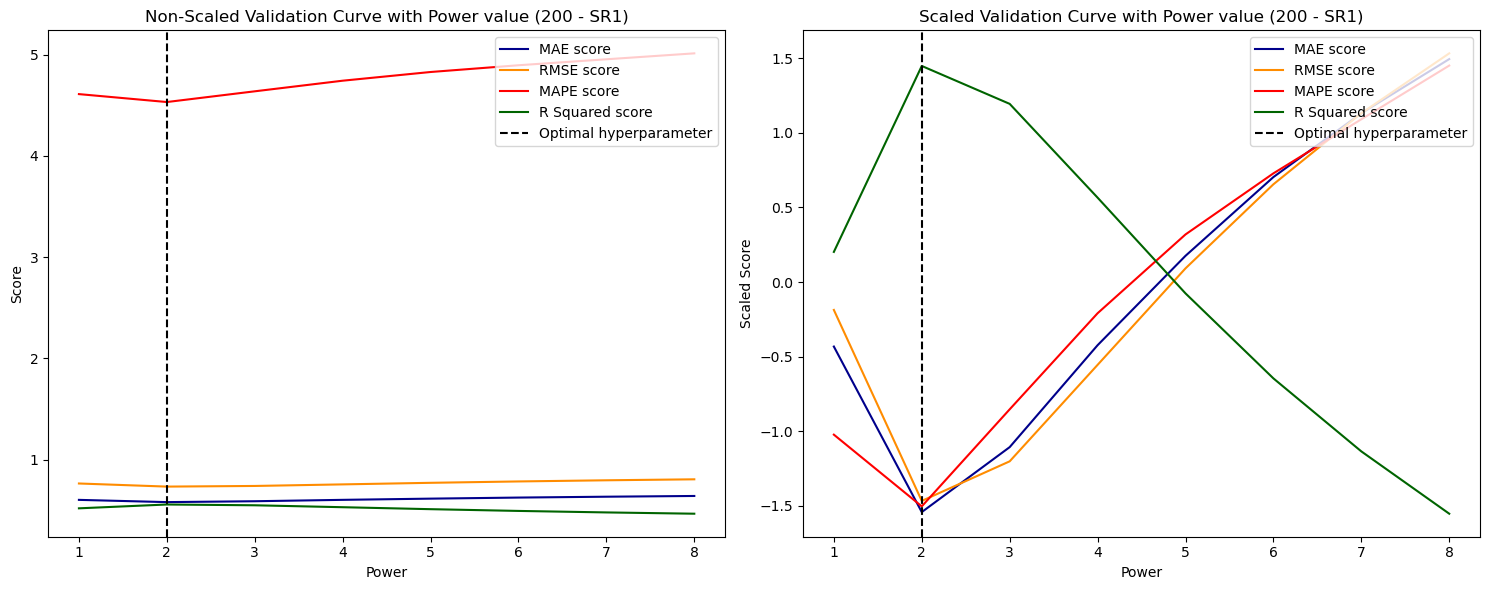

In [5]:
power = 2
df = pd.DataFrame(cv_score_list_200_power).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with Power value (200 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with Power value (200 - SR1)")

plt.tight_layout()
plt.show()

In [6]:
# Initialize an empty dictionary for storing scores
cv_score_list_200_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=2, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_200_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_200_n))

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_200_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.624129,0.589046,0.585589,0.581450,0.580248,0.581960,0.582340,0.584103,0.586282,0.588218
Validation Score RMSE,0.788087,0.745251,0.739636,0.734623,0.733859,0.735215,0.735878,0.737559,0.740269,0.742843
Validation Score MAPE,4.469222,4.659632,4.691547,4.530897,4.503969,4.366324,4.330634,4.241702,4.164408,4.119530
Validation Score R Squared,0.491137,0.544953,0.551783,0.557838,0.558758,0.557126,0.556327,0.554297,0.551016,0.547888


The smallest Validation Score MAE is 0.5802478734842087, found in n_neighbors 10.
The smallest Validation Score RMSE is 0.7338588727113619, found in n_neighbors 10.
The smallest Validation Score MAPE is 4.119530281547506, found in n_neighbors 20.
The largest Validation Score R Squared is 0.558758026662701, found in n_neighbors 10.
Validation Computation Time: 0.81 seconds


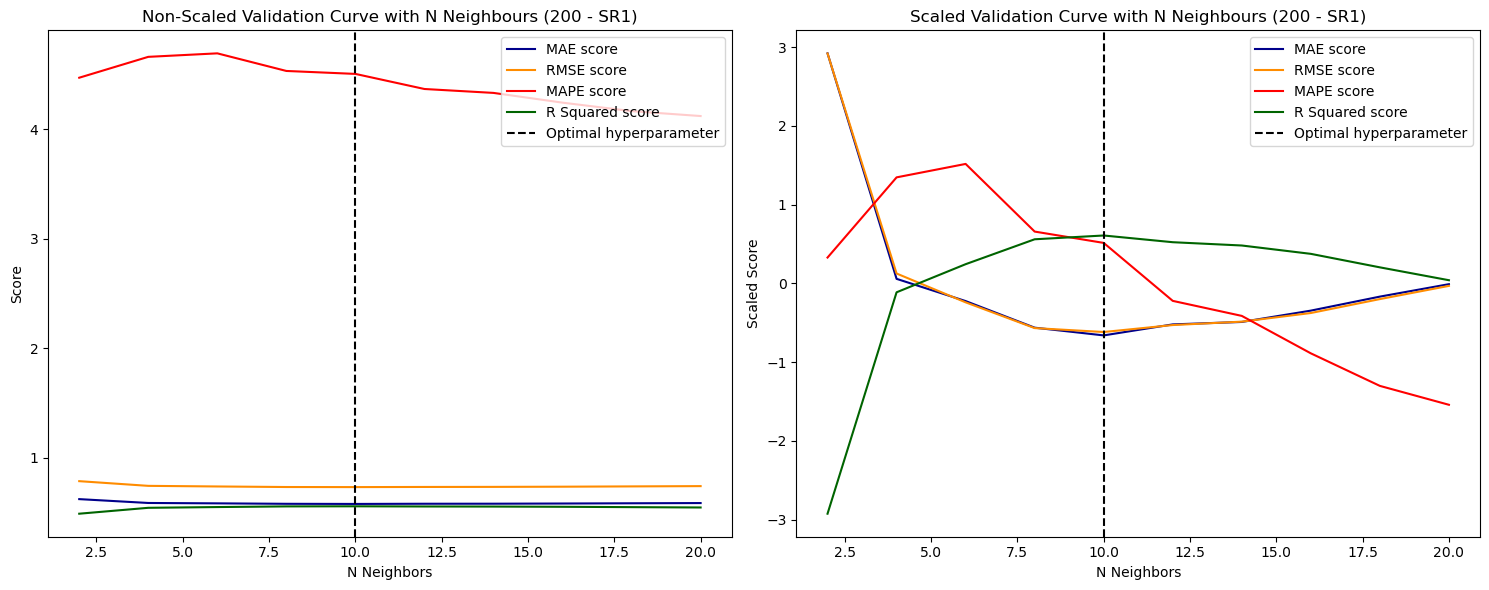

In [7]:
n_neighbors = 10
df = pd.DataFrame(cv_score_list_200_n).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with N Neighbours (200 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with N Neighbours (200 - SR1)")

plt.tight_layout()
plt.show()

# 400 points calibration

In [8]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal400.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal400.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal400.csv')

In [9]:
# Initialize an empty dictionary for storing scores
cv_score_list_400_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_400_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_400_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_400_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.547624,0.542492,0.557484,0.572756,0.585710,0.596732,0.605508,0.612321
Validation Score RMSE,0.694525,0.684997,0.701254,0.720342,0.736876,0.750349,0.761206,0.770007
Validation Score MAPE,5.064636,5.093166,5.161339,5.288289,5.379432,5.446414,5.501970,5.550732
Validation Score R Squared,0.604790,0.615559,0.597095,0.574863,0.555123,0.538706,0.525260,0.514218


The smallest Validation Score MAE is 0.5424923135522035, found in power 2.
The smallest Validation Score RMSE is 0.6849973284838458, found in power 2.
The smallest Validation Score MAPE is 5.064635900958383, found in power 1.
The largest Validation Score R Squared is 0.6155591978201624, found in power 2.
Validation Computation Time: 0.56 seconds


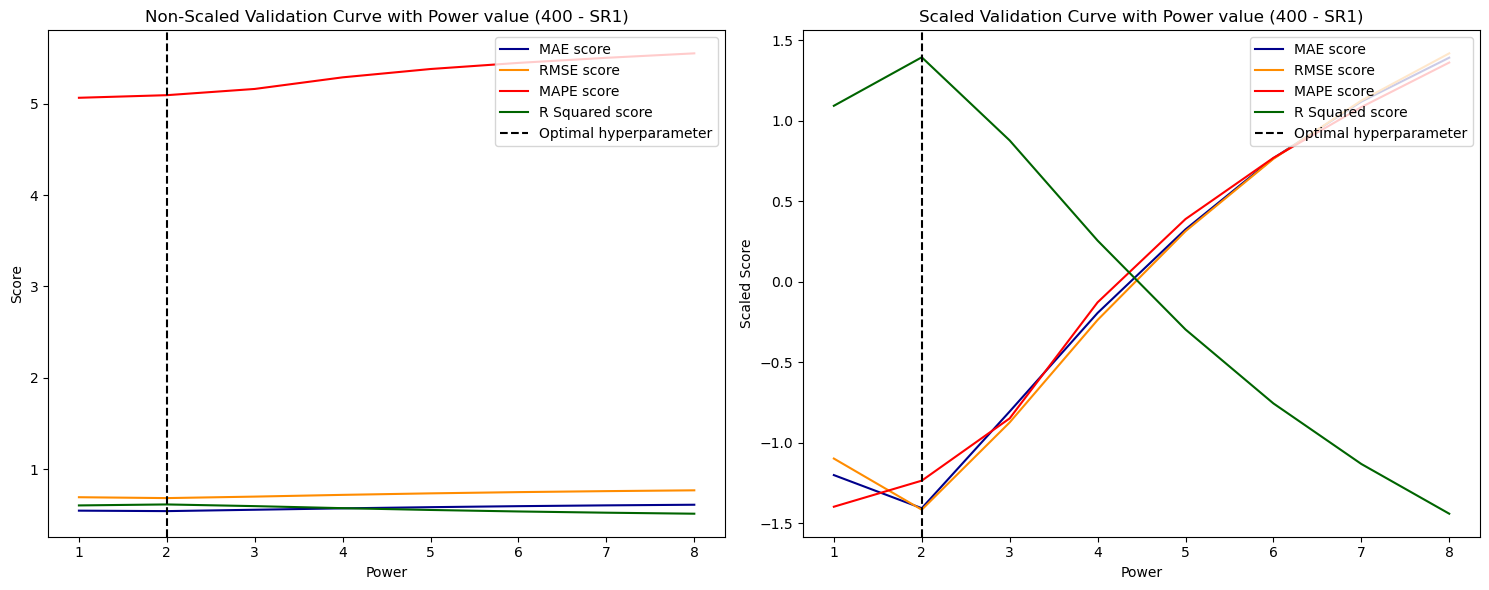

In [10]:
power = 2
df = pd.DataFrame(cv_score_list_400_power).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with Power value (400 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with Power value (400 - SR1)")

plt.tight_layout()
plt.show()

In [11]:
# Initialize an empty dictionary for storing scores
cv_score_list_400_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=2, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_400_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_400_n))

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_400_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.588929,0.552379,0.545161,0.542492,0.541426,0.539620,0.539829,0.539753,0.540424,0.540867
Validation Score RMSE,0.742097,0.696258,0.686991,0.684997,0.682389,0.680532,0.681093,0.680347,0.681085,0.681840
Validation Score MAPE,5.773039,4.989996,5.067016,5.093166,4.990375,4.861397,4.897776,4.842244,4.808897,4.762993
Validation Score R Squared,0.548796,0.602816,0.613318,0.615559,0.618481,0.620555,0.619929,0.620762,0.619938,0.619095


The smallest Validation Score MAE is 0.5396201236887253, found in n_neighbors 12.
The smallest Validation Score RMSE is 0.6803467701273384, found in n_neighbors 16.
The smallest Validation Score MAPE is 4.76299265237983, found in n_neighbors 20.
The largest Validation Score R Squared is 0.6207615402524973, found in n_neighbors 16.
Validation Computation Time: 0.76 seconds


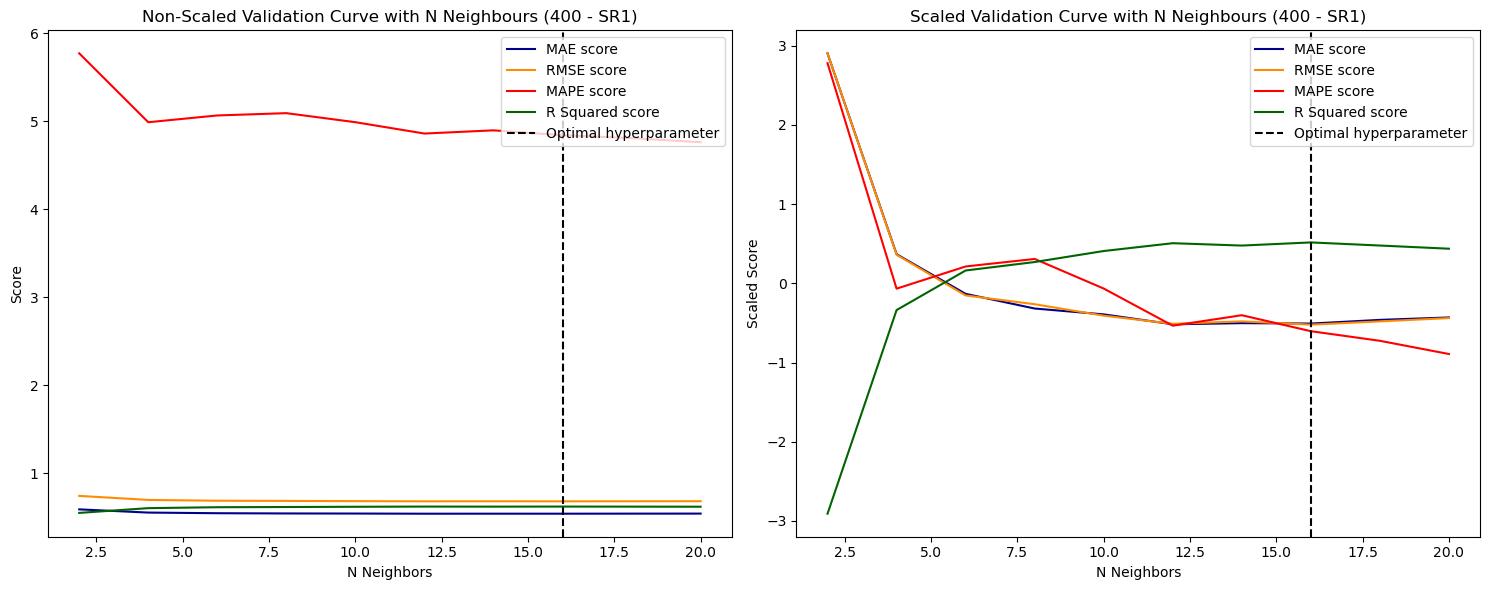

In [12]:
n_neighbors = 16
df = pd.DataFrame(cv_score_list_400_n).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with N Neighbours (400 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with N Neighbours (400 - SR1)")

plt.tight_layout()
plt.show()

# 600 points calibration

In [13]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal600.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal600.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal600.csv')

In [14]:
# Initialize an empty dictionary for storing scores
cv_score_list_600_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_600_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_600_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_600_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.510761,0.512161,0.529370,0.547215,0.561330,0.572352,0.581021,0.587620
Validation Score RMSE,0.648379,0.647517,0.668631,0.691065,0.709589,0.724082,0.735334,0.744117
Validation Score MAPE,4.545954,4.732301,4.885350,5.069708,5.199238,5.289038,5.358007,5.413950
Validation Score R Squared,0.655563,0.656478,0.633710,0.608718,0.587461,0.570437,0.556983,0.546336


The smallest Validation Score MAE is 0.5107610893824744, found in power 1.
The smallest Validation Score RMSE is 0.6475173649506147, found in power 2.
The smallest Validation Score MAPE is 4.545954215013477, found in power 1.
The largest Validation Score R Squared is 0.656477997505916, found in power 2.
Validation Computation Time: 0.53 seconds


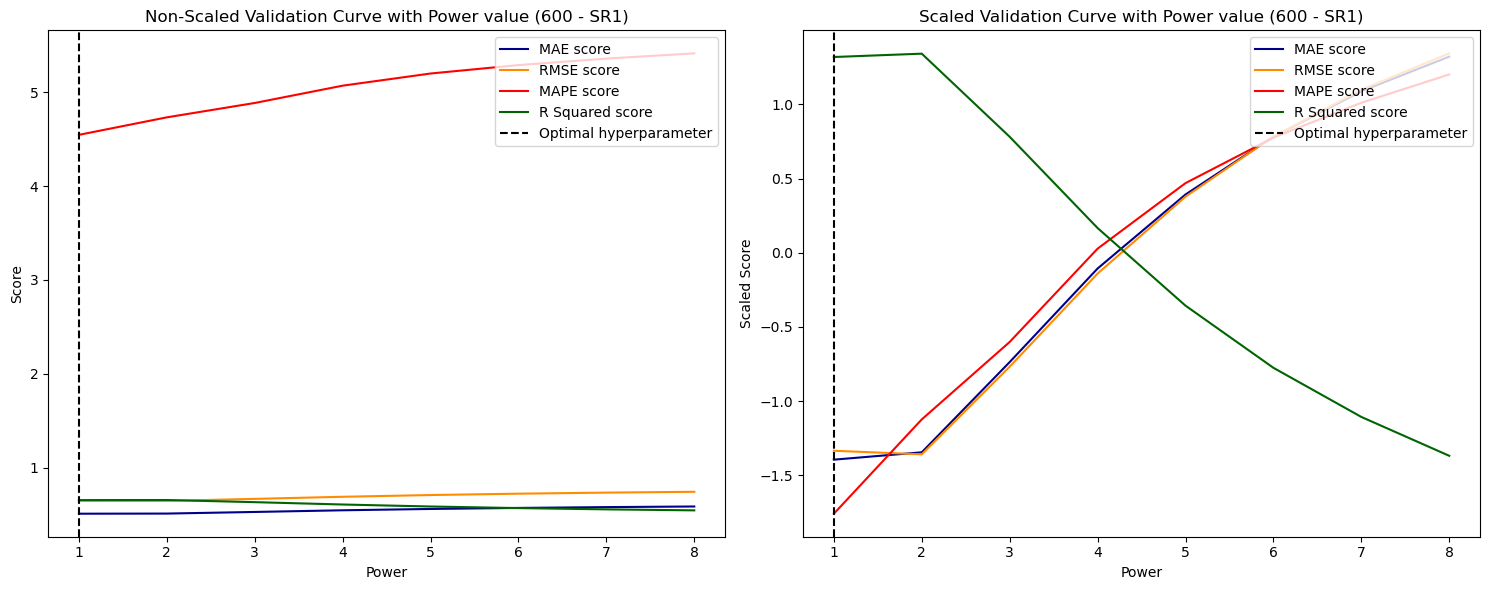

In [16]:
power = 1
df = pd.DataFrame(cv_score_list_600_power).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with Power value (600 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with Power value (600 - SR1)")

plt.tight_layout()
plt.show()

In [17]:
# Initialize an empty dictionary for storing scores
cv_score_list_600_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=1, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_600_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_600_n))

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_600_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.557597,0.520557,0.510400,0.510761,0.517367,0.523537,0.529384,0.533716,0.541367,0.546624
Validation Score RMSE,0.709062,0.654671,0.646566,0.648379,0.655100,0.662748,0.669188,0.674653,0.683449,0.689984
Validation Score MAPE,5.466045,4.651753,4.469770,4.545954,4.618688,4.554125,4.347162,4.213343,4.180526,4.205227
Validation Score R Squared,0.588073,0.648846,0.657487,0.655563,0.648385,0.640127,0.633100,0.627083,0.617295,0.609941


The smallest Validation Score MAE is 0.5103996739012019, found in n_neighbors 6.
The smallest Validation Score RMSE is 0.6465655355430964, found in n_neighbors 6.
The smallest Validation Score MAPE is 4.180526216195113, found in n_neighbors 18.
The largest Validation Score R Squared is 0.6574871875013617, found in n_neighbors 6.
Validation Computation Time: 0.64 seconds


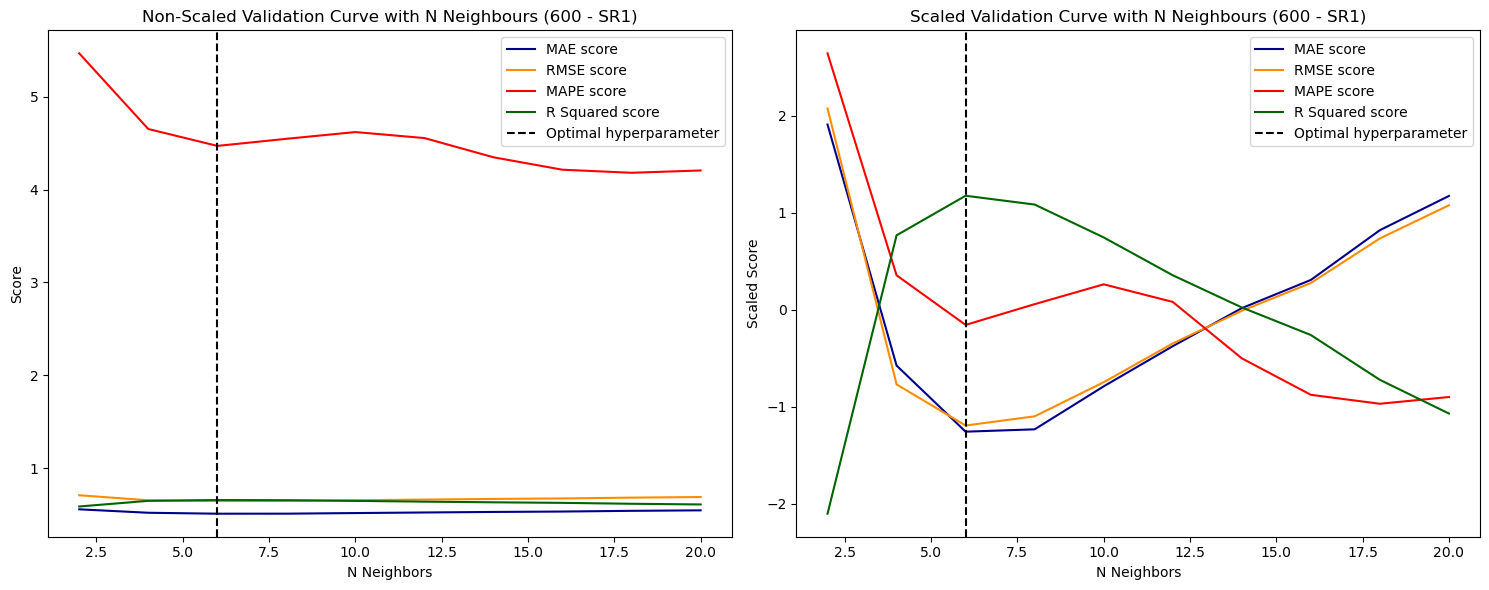

In [18]:
n_neighbors = 6
df = pd.DataFrame(cv_score_list_600_n).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with N Neighbours (600 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with N Neighbours (600 - SR1)")

plt.tight_layout()
plt.show()

# 800 points calibration

In [19]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal800.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal800.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal800.csv')

In [20]:
# Initialize an empty dictionary for storing scores
cv_score_list_800_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_800_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_800_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_800_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.497045,0.501072,0.519071,0.536062,0.549383,0.559573,0.567466,0.573593
Validation Score RMSE,0.625276,0.632041,0.655479,0.678073,0.696064,0.709982,0.720796,0.729289
Validation Score MAPE,4.540271,4.729186,4.915811,5.102883,5.245948,5.339095,5.408548,5.463288
Validation Score R Squared,0.679672,0.672703,0.647979,0.623293,0.603037,0.587003,0.574326,0.564236


The smallest Validation Score MAE is 0.4970449226273791, found in power 1.
The smallest Validation Score RMSE is 0.6252757625457899, found in power 1.
The smallest Validation Score MAPE is 4.540271129714469, found in power 1.
The largest Validation Score R Squared is 0.6796719954284807, found in power 1.
Validation Computation Time: 0.58 seconds


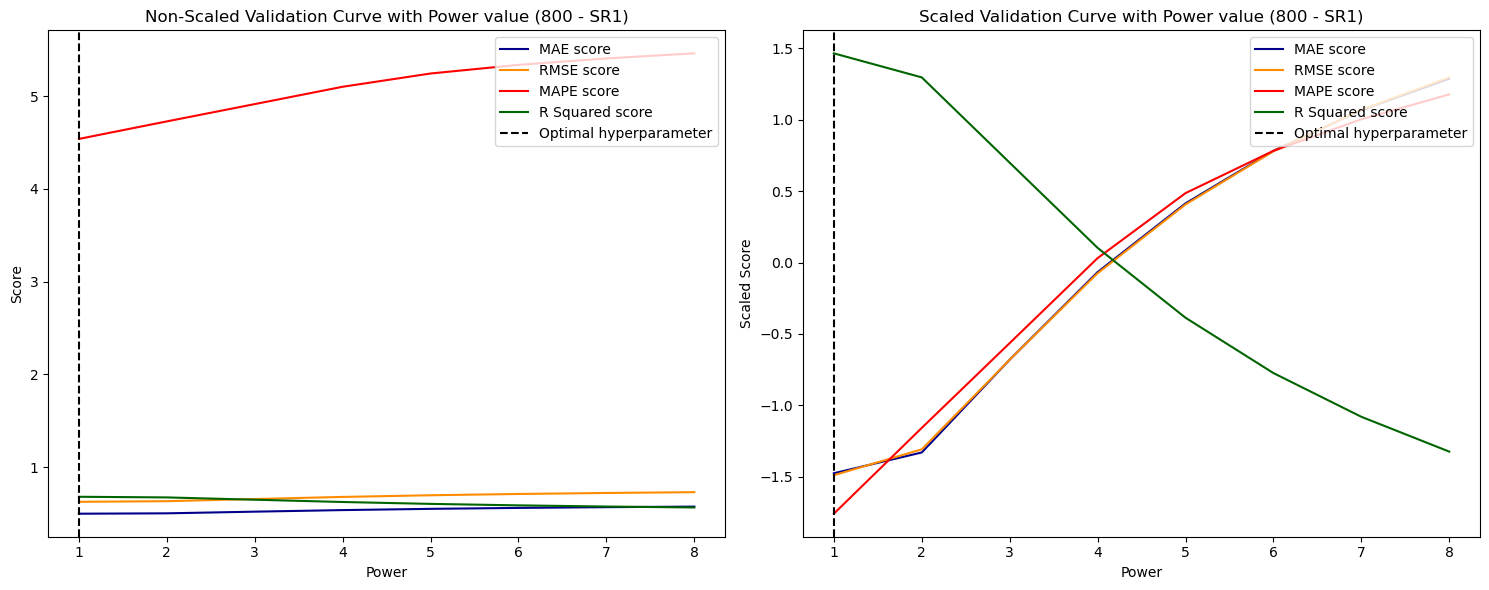

In [22]:
power = 1
df = pd.DataFrame(cv_score_list_800_power).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with Power value (800 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with Power value (800 - SR1)")

plt.tight_layout()
plt.show()

In [23]:
# Initialize an empty dictionary for storing scores
cv_score_list_800_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=1, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_800_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_800_n))

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_800_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.548544,0.509006,0.498666,0.497045,0.497141,0.503193,0.508698,0.514087,0.519453,0.523440
Validation Score RMSE,0.697395,0.640912,0.626528,0.625276,0.626087,0.633677,0.640513,0.647344,0.653635,0.659034
Validation Score MAPE,5.434568,4.484309,4.348028,4.540271,4.212683,4.324153,4.339523,4.205362,4.047993,3.938287
Validation Score R Squared,0.601518,0.663451,0.678388,0.679672,0.678840,0.671007,0.663869,0.656662,0.649957,0.644150


The smallest Validation Score MAE is 0.4970449226273791, found in n_neighbors 8.
The smallest Validation Score RMSE is 0.6252757625457899, found in n_neighbors 8.
The smallest Validation Score MAPE is 3.9382868888965508, found in n_neighbors 20.
The largest Validation Score R Squared is 0.6796719954284807, found in n_neighbors 8.
Validation Computation Time: 0.62 seconds


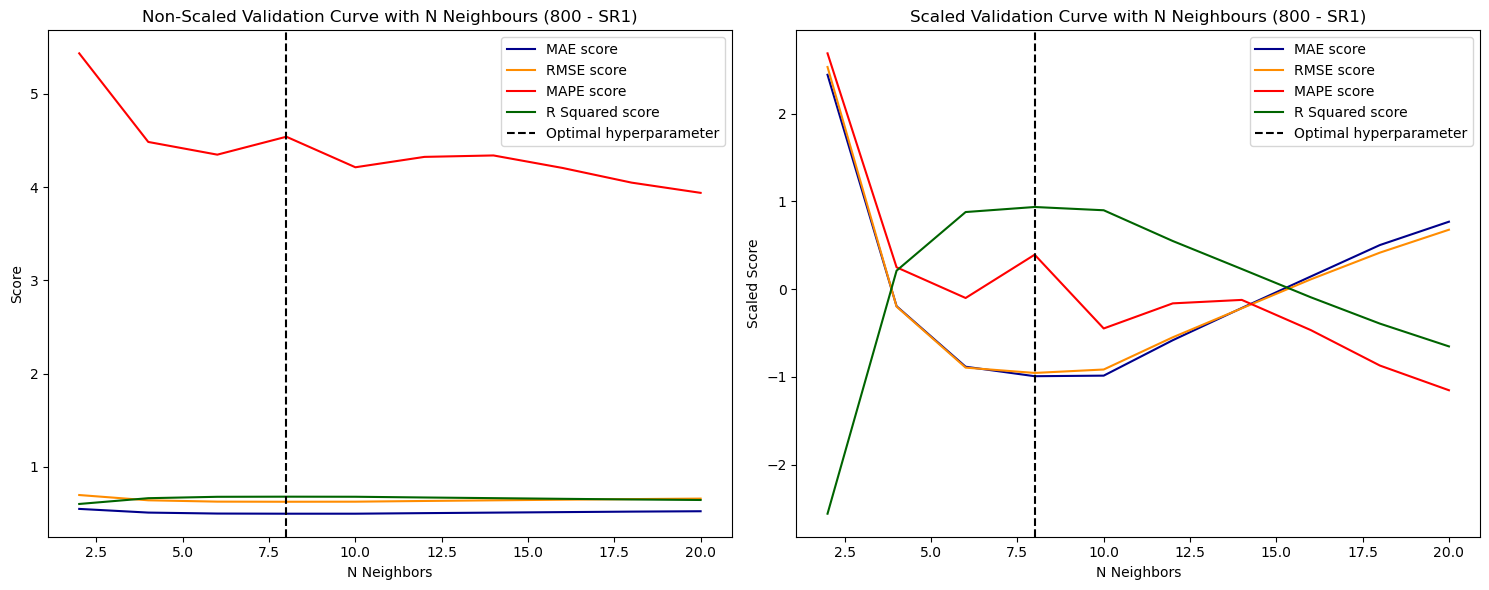

In [24]:
n_neighbors = 8
df = pd.DataFrame(cv_score_list_800_n).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with N Neighbours (800 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with N Neighbours (800 - SR1)")

plt.tight_layout()
plt.show()

# 1000 points calibration

In [25]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal1000.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal1000.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal1000.csv')

In [26]:
# Initialize an empty dictionary for storing scores
cv_score_list_1000_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1000_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1000_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1000_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.477542,0.484295,0.505427,0.525101,0.540311,0.551772,0.560335,0.566793
Validation Score RMSE,0.601736,0.612902,0.640328,0.666192,0.686441,0.701755,0.713303,0.722053
Validation Score MAPE,3.790188,3.917001,3.973050,3.935016,3.846159,4.139517,4.352745,4.504134
Validation Score R Squared,0.703337,0.692225,0.664064,0.636378,0.613937,0.596519,0.583131,0.572840


The smallest Validation Score MAE is 0.47754163343884576, found in power 1.
The smallest Validation Score RMSE is 0.6017359833393602, found in power 1.
The smallest Validation Score MAPE is 3.7901875072149105, found in power 1.
The largest Validation Score R Squared is 0.703336794668429, found in power 1.
Validation Computation Time: 0.53 seconds


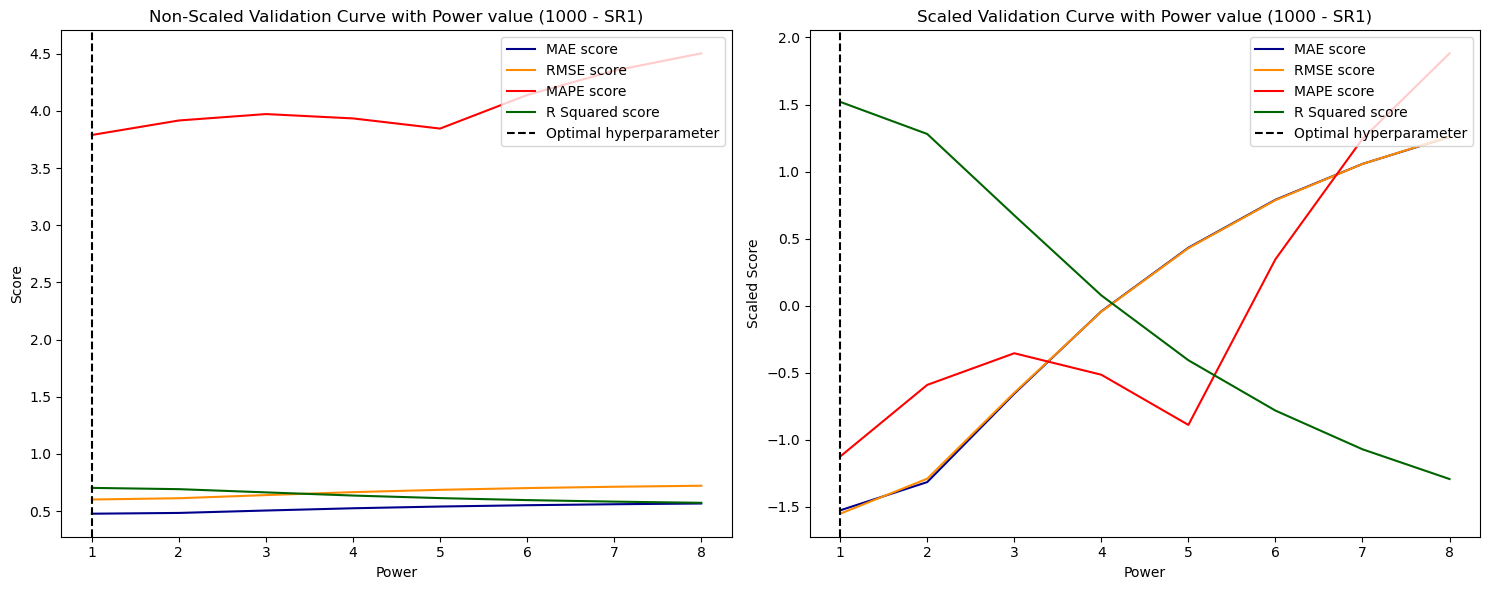

In [27]:
power = 1
df = pd.DataFrame(cv_score_list_1000_power).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with Power value (1000 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with Power value (1000 - SR1)")

plt.tight_layout()
plt.show()

In [28]:
# Initialize an empty dictionary for storing scores
cv_score_list_1000_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=1, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1000_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1000_n))  # Transposed for better readability

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1000_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.533684,0.492942,0.475690,0.477542,0.480481,0.482266,0.486885,0.490985,0.497162,0.503028
Validation Score RMSE,0.679251,0.619687,0.599864,0.601736,0.605059,0.607454,0.613378,0.619541,0.626557,0.633986
Validation Score MAPE,3.953172,3.874005,3.723631,3.790188,3.914329,3.904324,3.629513,3.736980,3.792513,3.879221
Validation Score R Squared,0.621982,0.685373,0.705180,0.703337,0.700052,0.697672,0.691746,0.685521,0.678358,0.670686


The smallest Validation Score MAE is 0.4756902366362642, found in n_neighbors 6.
The smallest Validation Score RMSE is 0.5998640263230025, found in n_neighbors 6.
The smallest Validation Score MAPE is 3.62951284030387, found in n_neighbors 14.
The largest Validation Score R Squared is 0.7051797190460098, found in n_neighbors 6.
Validation Computation Time: 0.66 seconds


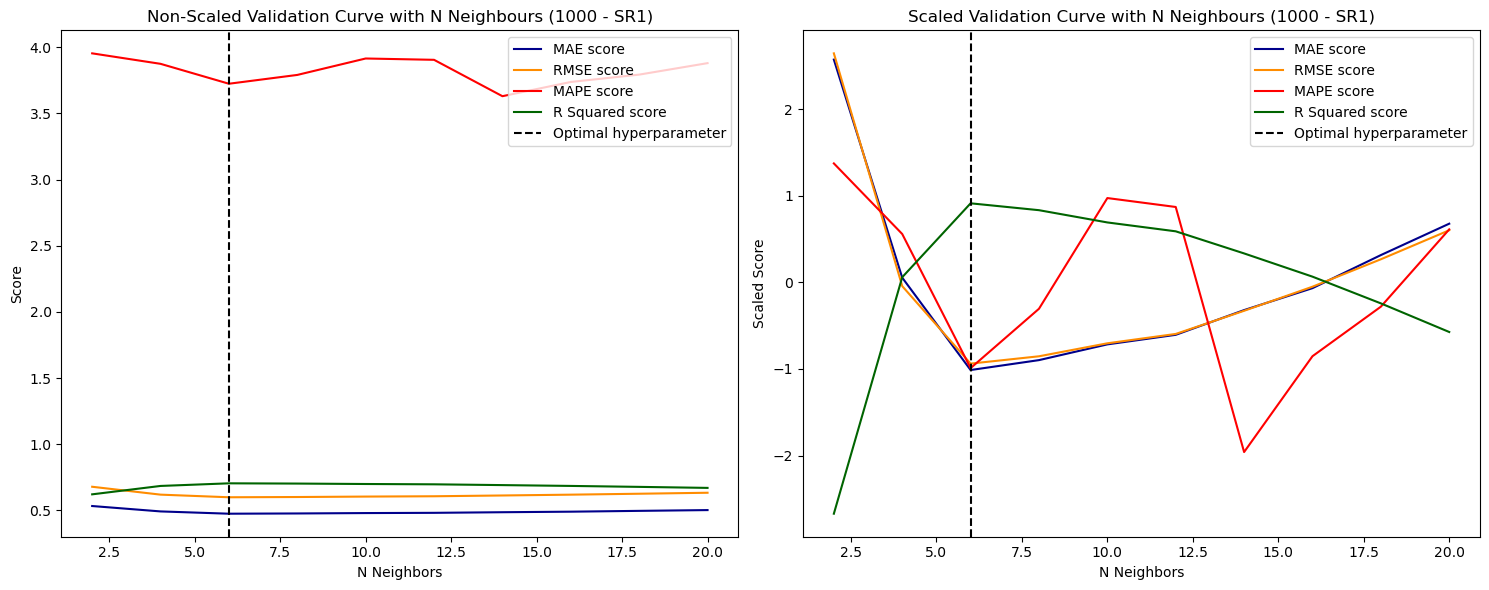

In [29]:
n_neighbors = 6
df = pd.DataFrame(cv_score_list_1000_n).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with N Neighbours (1000 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with N Neighbours (1000 - SR1)")

plt.tight_layout()
plt.show()

# 1500 points calibration

In [30]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal1500.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal1500.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal1500.csv')

In [31]:
# Initialize an empty dictionary for storing scores
cv_score_list_1500_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1500_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1500_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1500_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.463667,0.474348,0.495780,0.515736,0.530406,0.541433,0.549614,0.555658
Validation Score RMSE,0.583496,0.597348,0.624270,0.649579,0.669013,0.683382,0.694035,0.701992
Validation Score MAPE,3.819406,4.072090,4.283623,4.380827,4.418076,4.414396,4.390718,4.360540
Validation Score R Squared,0.721049,0.707648,0.680702,0.654287,0.633292,0.617371,0.605347,0.596246


The smallest Validation Score MAE is 0.46366729727604084, found in power 1.
The smallest Validation Score RMSE is 0.5834960694741129, found in power 1.
The smallest Validation Score MAPE is 3.81940611848786, found in power 1.
The largest Validation Score R Squared is 0.721049214200461, found in power 1.
Validation Computation Time: 0.57 seconds


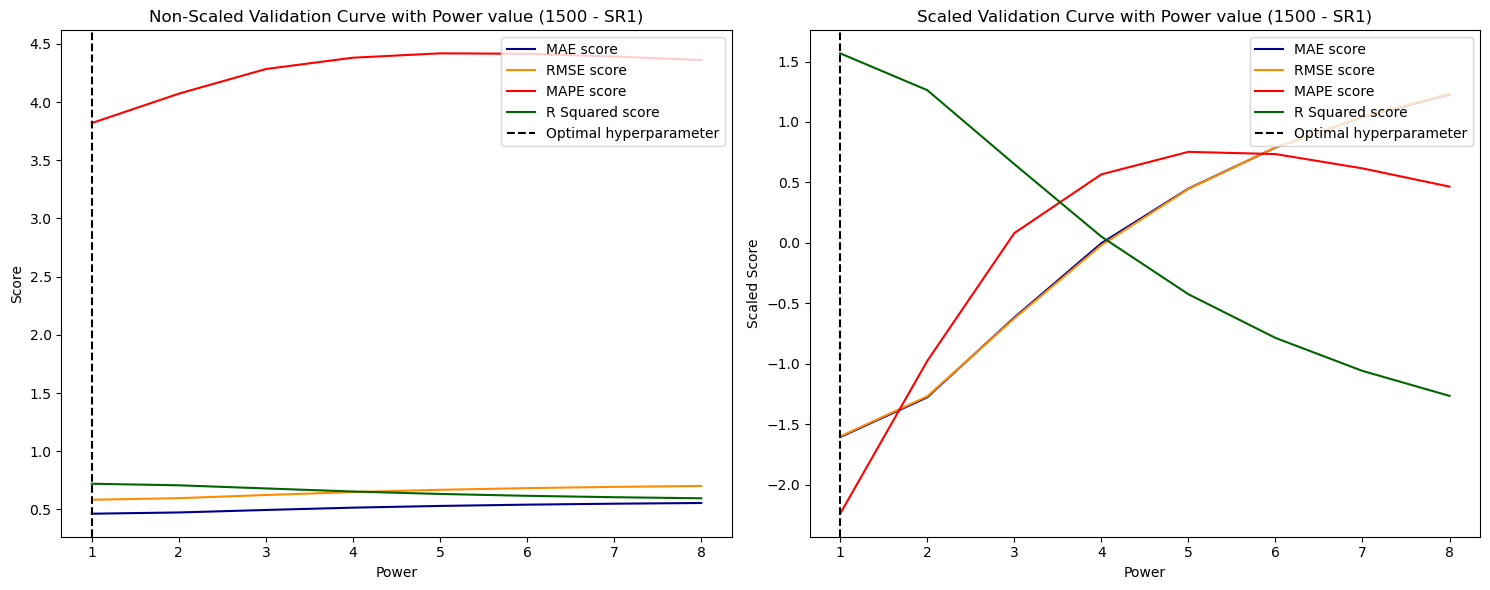

In [32]:
power = 1
df = pd.DataFrame(cv_score_list_1500_power).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with Power value (1500 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with Power value (1500 - SR1)")

plt.tight_layout()
plt.show()

In [33]:
# Initialize an empty dictionary for storing scores
cv_score_list_1500_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=1, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1500_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1500_n))  # Transposed for better readability

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1500_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.525252,0.487049,0.467936,0.463667,0.462912,0.463818,0.465920,0.469587,0.470973,0.474531
Validation Score RMSE,0.661161,0.613523,0.590519,0.583496,0.582519,0.583485,0.586788,0.592155,0.594591,0.599476
Validation Score MAPE,4.014938,4.248799,3.950008,3.819406,3.701088,3.465321,3.544330,3.388551,3.435282,3.346627
Validation Score R Squared,0.641849,0.691601,0.714294,0.721049,0.721983,0.721060,0.717893,0.712709,0.710340,0.705561


The smallest Validation Score MAE is 0.46291198677609624, found in n_neighbors 10.
The smallest Validation Score RMSE is 0.5825191017968989, found in n_neighbors 10.
The smallest Validation Score MAPE is 3.3466267011713775, found in n_neighbors 20.
The largest Validation Score R Squared is 0.7219825461138281, found in n_neighbors 10.
Validation Computation Time: 0.63 seconds


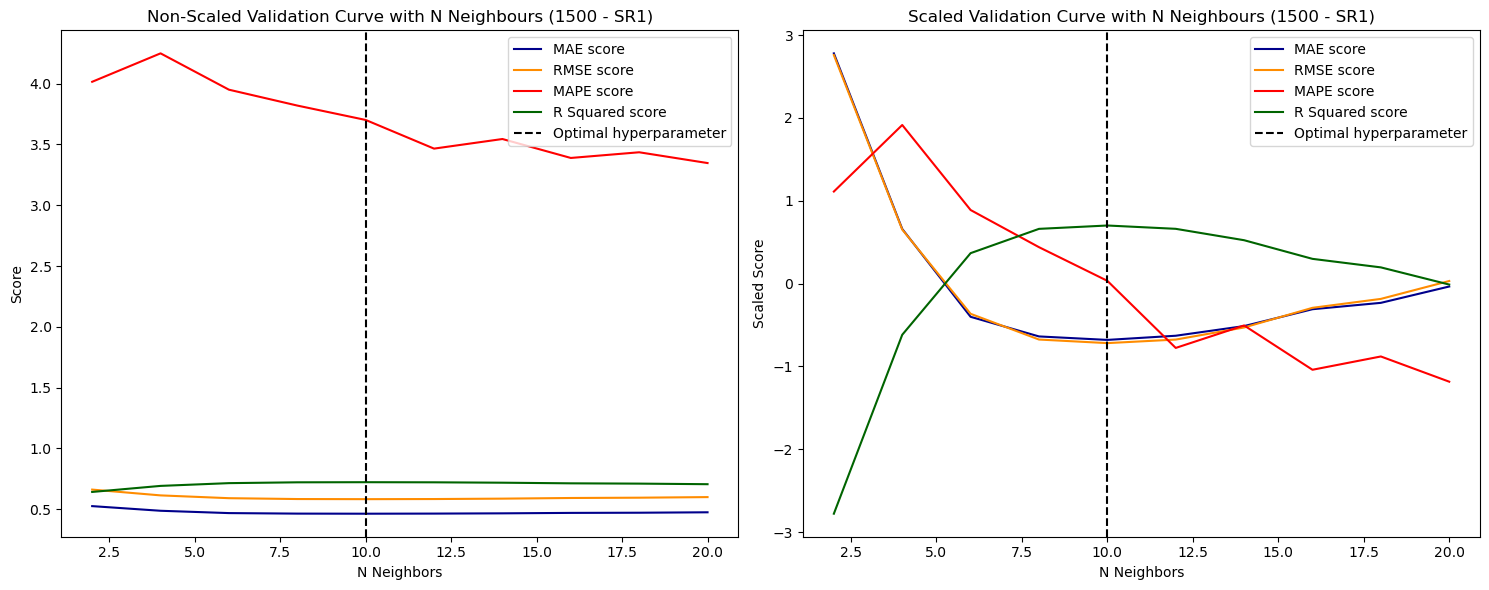

In [34]:
n_neighbors = 10
df = pd.DataFrame(cv_score_list_1500_n).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with N Neighbours (1500 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with N Neighbours (1500 - SR1)")

plt.tight_layout()
plt.show()

# 2000 points calibration

In [35]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR1_input_randomfield_cal2000.csv')
val_df = pd.read_csv(f'{file_path}val_SR1_input_randomfield_cal2000.csv')
test_df = pd.read_csv(f'{file_path}test_SR1_input_randomfield_cal2000.csv')

In [36]:
# Initialize an empty dictionary for storing scores
cv_score_list_2000_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_2000_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_2000_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_2000_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.446230,0.457201,0.476724,0.495604,0.510766,0.522514,0.531315,0.537929
Validation Score RMSE,0.564336,0.576580,0.600809,0.624974,0.644025,0.658073,0.668357,0.675933
Validation Score MAPE,2.855731,3.130784,3.775028,4.131097,4.326583,4.426143,4.479956,4.511165
Validation Score R Squared,0.739068,0.727623,0.704250,0.679981,0.660174,0.645186,0.634010,0.625666


The smallest Validation Score MAE is 0.4462304277036879, found in power 1.
The smallest Validation Score RMSE is 0.5643360261767926, found in power 1.
The smallest Validation Score MAPE is 2.855730682143914, found in power 1.
The largest Validation Score R Squared is 0.7390680434481982, found in power 1.
Validation Computation Time: 0.56 seconds


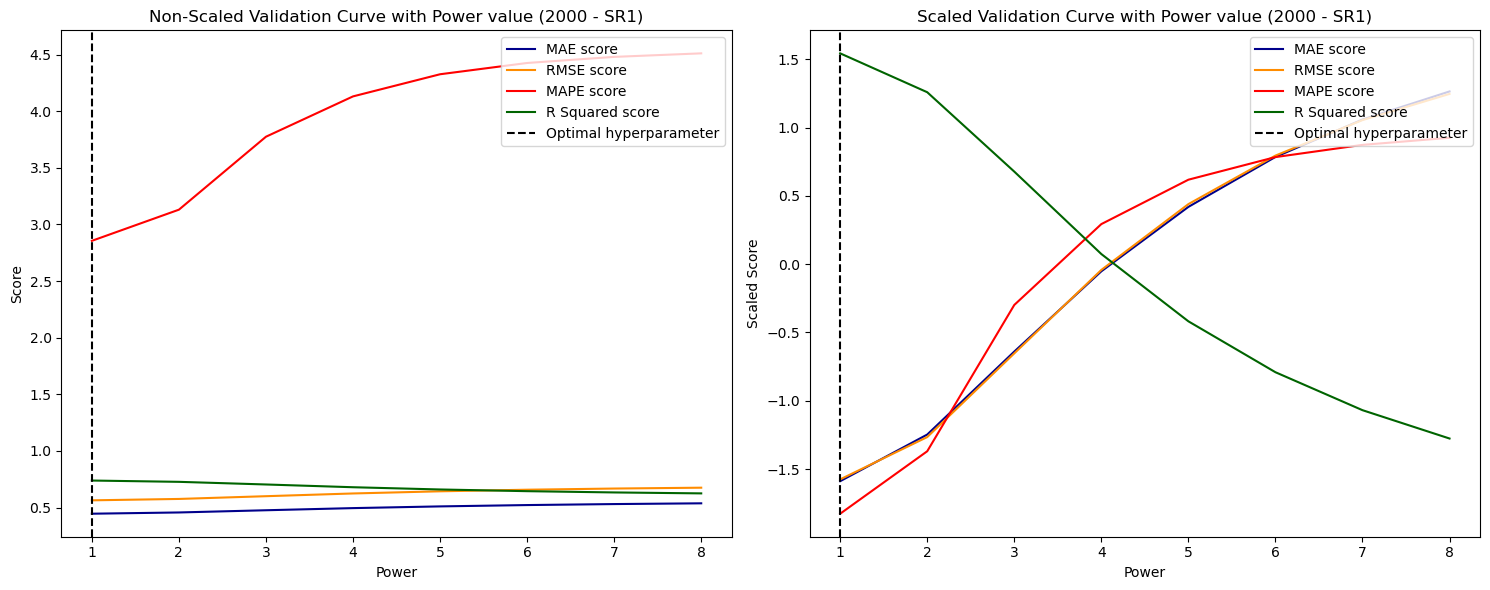

In [37]:
power = 1
df = pd.DataFrame(cv_score_list_2000_power).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with Power value (2000 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with Power value (2000 - SR1)")

plt.tight_layout()
plt.show()

In [38]:
# Initialize an empty dictionary for storing scores
cv_score_list_2000_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=1, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_2000_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_2000_n))  # Transposed for better readability

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_2000_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.506858,0.468762,0.453512,0.446230,0.443858,0.444657,0.445881,0.447011,0.450245,0.453702
Validation Score RMSE,0.636216,0.591559,0.571969,0.564336,0.560049,0.560390,0.562313,0.564643,0.568581,0.573165
Validation Score MAPE,3.818867,3.173997,2.787243,2.855731,2.735370,2.808047,2.887197,2.904772,3.033575,3.023839
Validation Score R Squared,0.668364,0.713286,0.731962,0.739068,0.743017,0.742705,0.740936,0.738784,0.735128,0.730840


The smallest Validation Score MAE is 0.4438580810135134, found in n_neighbors 10.
The smallest Validation Score RMSE is 0.5600491014917228, found in n_neighbors 10.
The smallest Validation Score MAPE is 2.735370036930155, found in n_neighbors 10.
The largest Validation Score R Squared is 0.7430172756131547, found in n_neighbors 10.
Validation Computation Time: 0.66 seconds


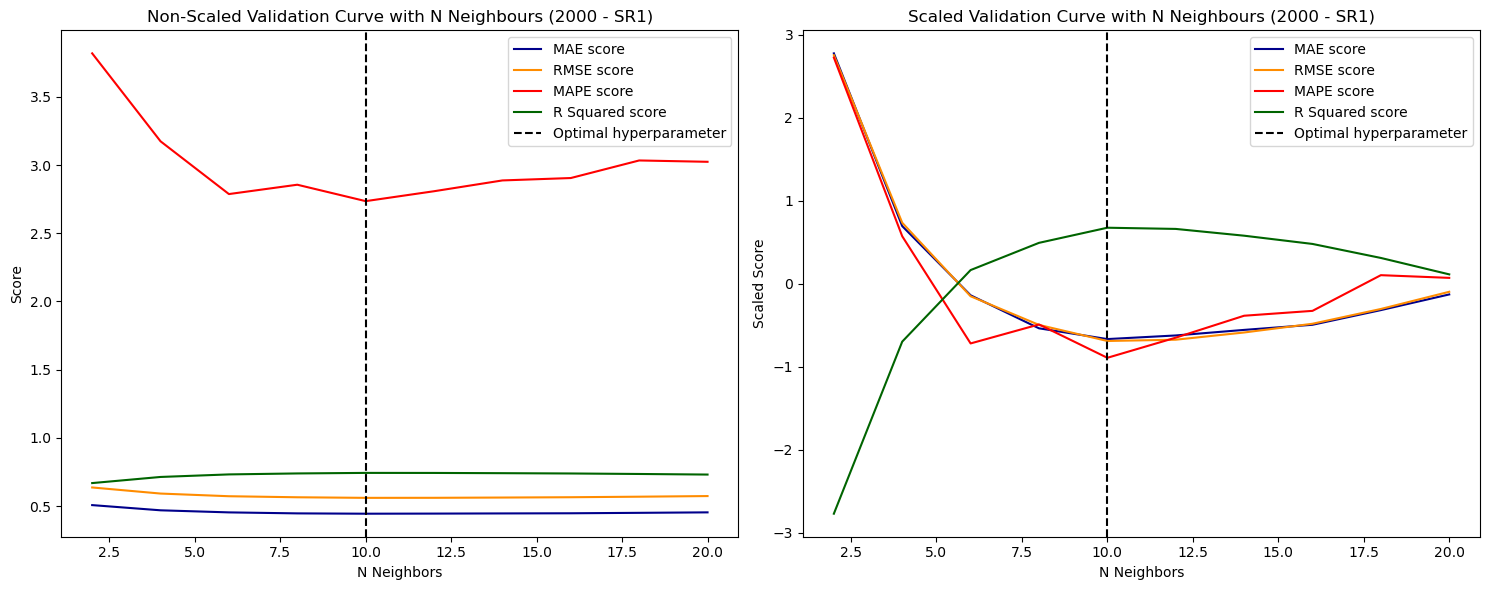

In [39]:
n_neighbors = 10
df = pd.DataFrame(cv_score_list_2000_n).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with N Neighbours (2000 - SR1)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with N Neighbours (2000 - SR1)")

plt.tight_layout()
plt.show()

## Validation score as calibration set size increases

In [40]:
def calculate_means(data_structures):
    all_means = {}
    for structure_id, data in enumerate(data_structures, 1):
        means = {key: sum(d[key] for d in data.values()) / len(data) for key in data[next(iter(data))]}
        all_means[f"Structure {structure_id}"] = means
    return all_means

# List of data structures
data_structures_n = [cv_score_list_200_n, cv_score_list_400_n, cv_score_list_600_n, cv_score_list_800_n,cv_score_list_1000_n,cv_score_list_1500_n, cv_score_list_2000_n]
data_structures_power = [cv_score_list_200_power, cv_score_list_400_power, cv_score_list_600_power,cv_score_list_800_power,cv_score_list_1000_power,cv_score_list_1500_power, cv_score_list_2000_power]

# Calculate means
all_means_n = calculate_means(data_structures_n)
all_means_power = calculate_means(data_structures_power)

In [41]:
new_keys = [200, 400, 600, 800, 1000, 1500, 2000]

# Function to replace keys
def replace_keys(structures, new_keys):
    # Make sure there are enough new keys for the structures
    if len(new_keys) < len(structures):
        raise ValueError("Not enough new keys for the number of structures")

    # New dictionary to store replaced key structures
    replaced_structures = {}

    # Use zip to iterate over both the items in structures and the new_keys simultaneously
    for new_key, (old_key, value) in zip(new_keys, structures.items()):
        replaced_structures[new_key] = value

    return replaced_structures

all_means_n = replace_keys(all_means_n, new_keys)
all_means_power = replace_keys(all_means_power, new_keys)

In [42]:
cal_size = [200, 400, 600, 800, 1000, 1500, 2000]
all_means_power_df = pd.DataFrame(all_means_power).T
all_means_n_df = pd.DataFrame(all_means_n).T
all_means_n_df

,Validation Score MAE,Validation Score RMSE,Validation Score MAPE,Validation Score R Squared
200,0.588336,0.743322,4.407787,0.547112
400,0.547088,0.689763,5.008690,0.609925
600,0.529131,0.669380,4.525259,0.632590
800,0.511927,0.645040,4.387518,0.658751
1000,0.492067,0.620651,3.819788,0.683990
1500,0.475165,0.598771,3.691435,0.705834
2000,0.456072,0.575322,3.002864,0.728409


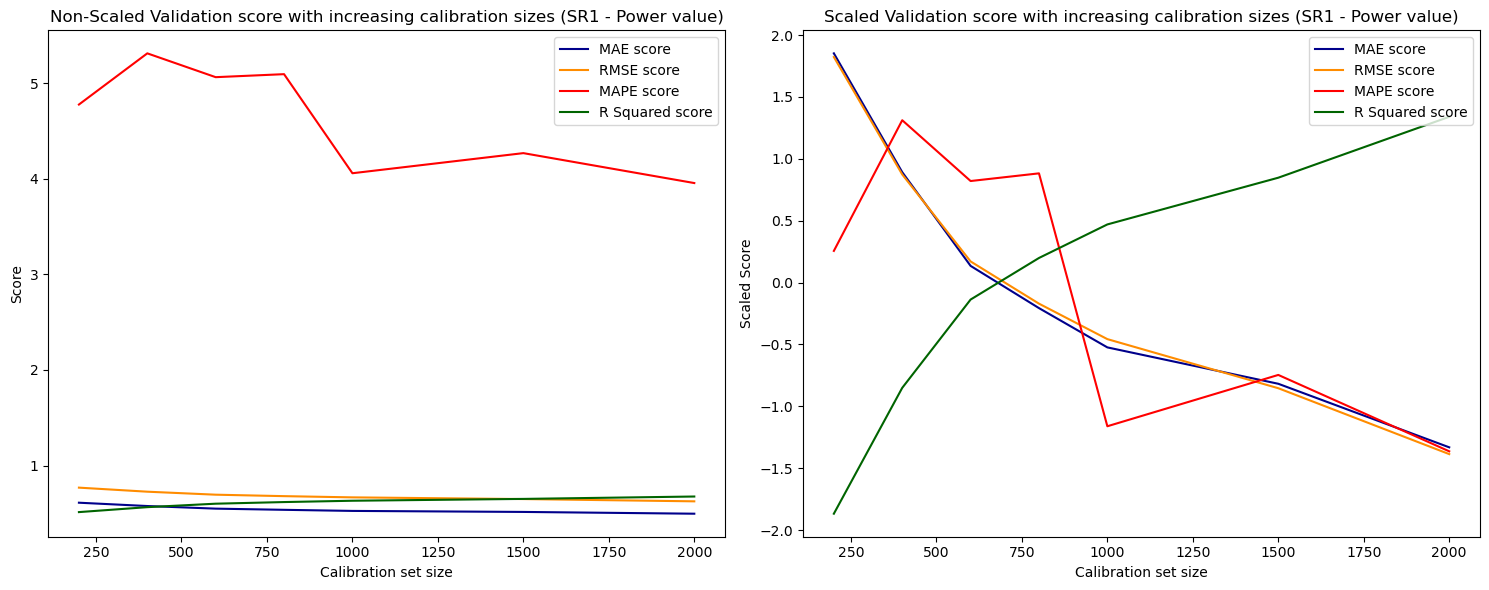

In [43]:
# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(all_means_power_df), columns=all_means_power_df.columns, index=all_means_power_df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(cal_size, all_means_power_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(cal_size, all_means_power_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(cal_size, all_means_power_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(cal_size, all_means_power_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].set_xlabel('Calibration set size')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation score with increasing calibration sizes (SR1 - Power value)")

# Plot normalized data on the second subplot
ax[1].plot(cal_size, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(cal_size, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(cal_size, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(cal_size, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].set_xlabel('Calibration set size')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation score with increasing calibration sizes (SR1 - Power value)")

plt.tight_layout()
plt.show()

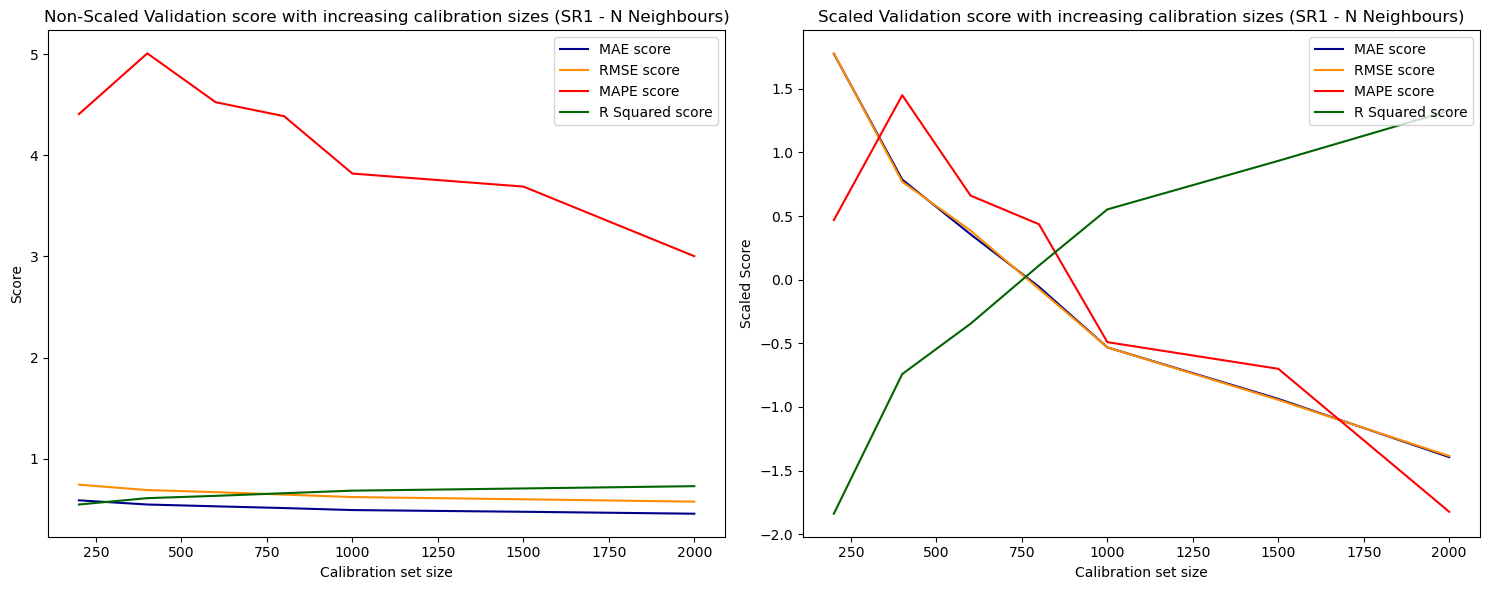

In [44]:
# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(all_means_n_df), columns=all_means_n_df.columns, index=all_means_n_df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(cal_size, all_means_n_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(cal_size, all_means_n_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(cal_size, all_means_n_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(cal_size, all_means_n_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].set_xlabel('Calibration set size')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation score with increasing calibration sizes (SR1 - N Neighbours)")

# Plot normalized data on the second subplot
ax[1].plot(cal_size, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(cal_size, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(cal_size, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(cal_size, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].set_xlabel('Calibration set size')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation score with increasing calibration sizes (SR1 - N Neighbours)")

plt.tight_layout()
plt.show()

## Testing model (Final Performance Metrics)

In [45]:
filenames = ['SR1_input_randomfield_cal200','SR1_input_randomfield_cal400', 'SR1_input_randomfield_cal600',
             'SR1_input_randomfield_cal800', 'SR1_input_randomfield_cal1000', 'SR1_input_randomfield_cal1500', 'SR1_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
combined_df = pd.DataFrame()
for file in filenames:
    cal_df = pd.read_csv(f'Synthetic Data/SR1/cal_{file}.csv')
    combined_df = pd.concat([cal_df, combined_df], ignore_index=True)

combined_df = pd.concat([val_df, combined_df], ignore_index=True)
combined_df = combined_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

combined_df #All caliration points and validation data points

,x,y,z
0,39,4,-1.774013
1,47,42,-0.393699
2,92,88,-0.462323
3,24,43,0.601361
4,37,92,-0.129720
...,...,...,...
3995,93,12,-3.037629
3996,56,25,0.688154
3997,22,8,-0.676579
3998,38,35,-0.744753


In [46]:
eval_combined_array_coordinates = np.array([list(pair) for pair in zip(combined_df['x'], combined_df['y'])])

start_time = time.time()

idw_model = ShepardIDWInterpolator(eval_combined_array_coordinates, combined_df['z'])

 # Predict at test locations
eval_combined_array_test = np.array([list(pair) for pair in zip(test_df['x'], test_df['y'])])
z_pred_test = idw_model.__call__(eval_combined_array_test, power = 1, n_neighbors = 10)

rmse = np.sqrt(mean_squared_error(test_df['z'], z_pred_test))
mae = mean_absolute_error(test_df['z'], z_pred_test)
mape = mean_absolute_percentage_error(test_df['z'], z_pred_test)
r2 = r2_score(test_df['z'], z_pred_test)

end_time = time.time()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

MAE: 0.43425292639534757
RMSE: 0.5439501353958516
MAPE: 2.0113057392738707
R Squared: 0.7644179655392721
Testing Computation Time: 0.08 seconds


### Plotting Spatial Interpolation of entire area with Model

In [48]:
filenames = ['cal_SR1_input_randomfield_cal200', 'cal_SR1_input_randomfield_cal400', 'cal_SR1_input_randomfield_cal600', 'cal_SR1_input_randomfield_cal800', 'cal_SR1_input_randomfield_cal1000', 'cal_SR1_input_randomfield_cal1500', 'cal_SR1_input_randomfield_cal2000',
            'val_SR1_input_randomfield_cal2000', 'test_SR1_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
all_df = pd.DataFrame()
for file in filenames:
    df = pd.read_csv(f'Synthetic Data/SR1/{file}.csv')
    all_df = pd.concat([df, all_df], ignore_index=True)

all_df = all_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

all_df #All calbration, validation and test data points

,x,y,z
0,83,56,-1.154367
1,40,74,-0.398708
2,90,28,-0.161047
3,51,84,-1.042425
4,32,48,-1.328360
...,...,...,...
5995,93,12,-3.037629
5996,56,25,0.688154
5997,22,8,-0.676579
5998,38,35,-0.744753


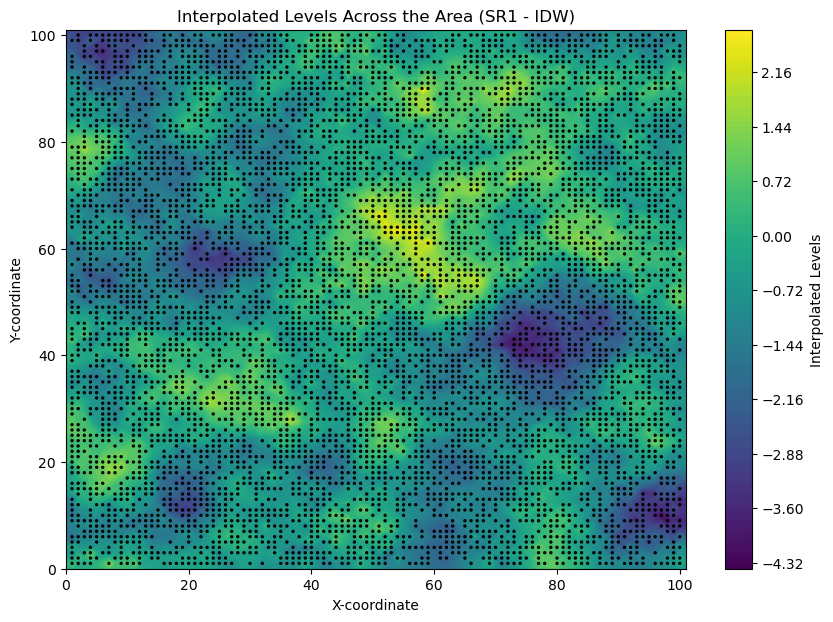

Spatial Interpolation Computation Time: 0.30 seconds


In [50]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'z'
observed_locations = all_df[observed_location_columns].values
observed_values = all_df[observed_values_column].values

# Initialize IDW model
idw_model = ShepardIDWInterpolator(observed_locations, observed_values)

# Start timing spatial interpolation
start_time_interpolation = time.time()

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = idw_model.__call__(grid_points, power = 2, n_neighbors = 10)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Levels')
plt.scatter(all_df['x'], all_df['y'], c=all_df['z'], cmap='viridis', edgecolor='k', label='Observed', s= 2.0)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
#plt.legend()
plt.title('Interpolated Levels Across the Area (SR1 - IDW)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")